In [0]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-ffmm50a2
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-ffmm50a2
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.05b668950c1b5505db34907fb6629c5bd9437fb0a_-cp36-none-any.whl size=113930 sha256=c3aa2e38046f40a9a33b0b039b7bec4fab56bb5bf01ee603fba9e1c0c7a1f289
  Stored in directory: /tmp/pip-ephem-wheel-cache-pf4zm43x/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [0]:
import urllib

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
AUTOTUNE = tf.data.experimental.AUTOTUNE

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

import tensorflow_datasets as tfds

import PIL.Image

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 5)

import numpy as np

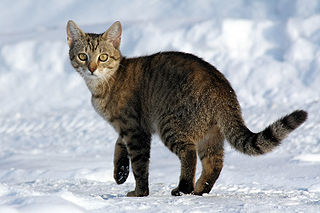

In [0]:
image_path = tf.keras.utils.get_file('cats.jpg', "https://storage.googleapis.com/download.tensorflow.org/example_images/320px-Felis_catus-cat_on_snow.jpg")
PIL.Image.open(image_path)

In [0]:
image_path

'/root/.keras/datasets/cats.jpg'

In [0]:
image_string = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image_string, channels = 3)

In [0]:
# augmented image vs real image

In [0]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1, 2, 1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1, 2, 2)
  plt.title('Augmented image')
  plt.imshow(augmented)

In [0]:
#flipping the image

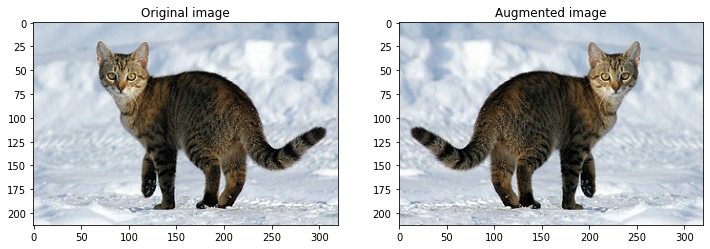

In [0]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

In [0]:
# grayscale the image

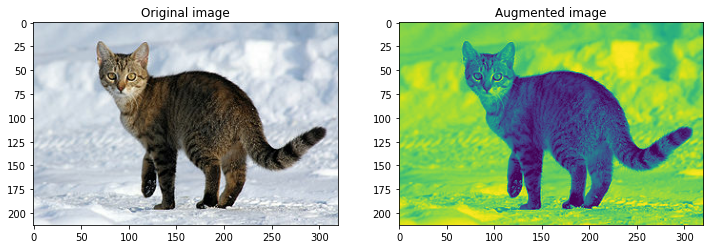

In [0]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))

In [0]:
# saturate the image

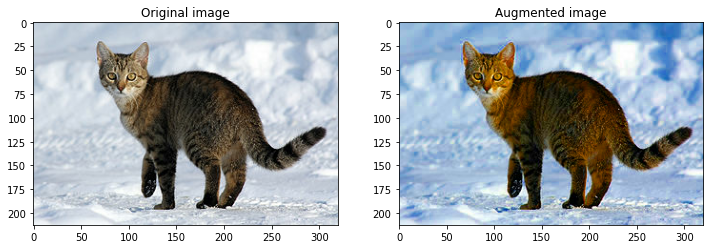

In [0]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

In [0]:
# changing the brightness

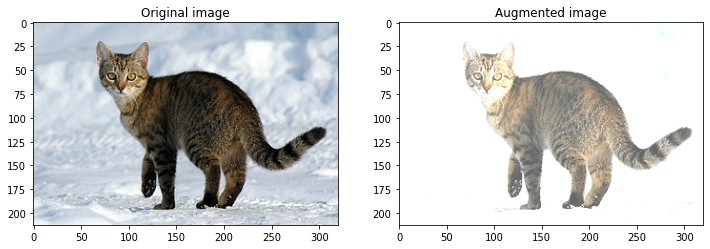

In [0]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

In [0]:
# rotate the image

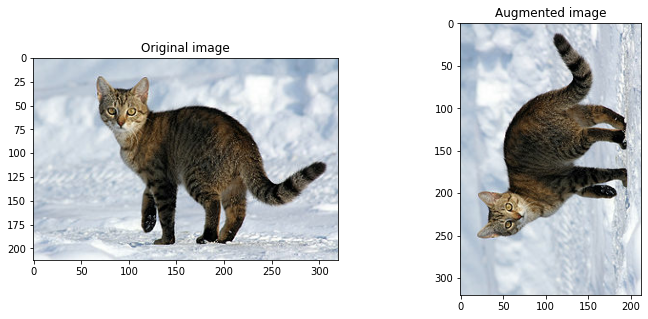

In [0]:
rotate = tf.image.rot90(image)
visualize(image,rotate)

In [0]:
# center crop the imagge

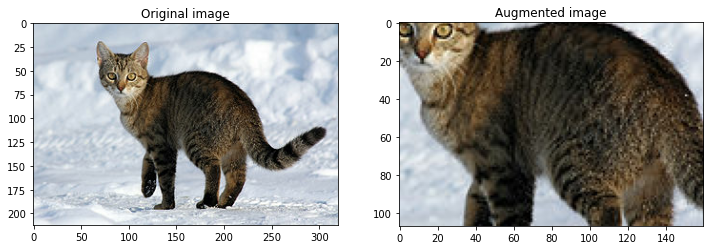

In [0]:
crop = tf.image.central_crop(image, central_fraction = 0.5)
visualize(image, crop)

In [0]:
# now lets train and augment the whole dataset

In [0]:
dataset, info =  tfds.load('mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

num_train_examples= info.splits['train'].num_examples

In [0]:
# preprocessing the data

In [0]:
def convert(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, label



In [0]:
def augment(image, label):
    image, label = convert(image, label)
    image = tf.image.resize_with_crop_or_pad(image, 34, 34) # Add 6 pixels of padding
    image = tf.image.random_crop(image, size = [28, 28, 1])
    image = tf.image.random_brightness(image, max_delta = 0.5)
    return image, label

In [0]:
batch_size = 64
num_examples = 2048

In [0]:
# augmented batches

In [0]:
augmented_train_data = train_dataset.take(num_examples).cache().shuffle(num_train_examples//4).map(augment, num_parallel_calls = AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE)

In [0]:
#non-augmented batches

In [0]:
non_augmented_train_batches = train_dataset.take(num_examples).cache().shuffle(num_train_examples//4).map(convert, num_parallel_calls = AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE)

In [0]:
# validation dataset

In [0]:
validation_batches = test_dataset.map(convert, num_parallel_calls = AUTOTUNE).batch(2*batch_size)

In [0]:
def make_model():
    model = tf.keras.Sequential([
                                 layers.Flatten(input_shape = (28, 28, 1)), 
                                 layers.Dense(4096, activation = 'relu'),
                                 layers.Dense(4096, activation = 'relu'),
                                 layers.Dense(10)
    ])

    model.compile(optimizer = 'adam', loss = tf.losses.SparseCategoricalCrossentropy(from_logits = True), metrics = ['accuracy'])

    return model

In [0]:
# trianing the model

In [0]:
model_without_aug = make_model()
no_aug_history = model_without_aug.fit(non_augmented_train_batches, epochs = 50, validation_data = validation_batches)

Epoch 1/50
32/32 [==============================] - 16s 510ms/step - loss: 0.9515 - accuracy: 0.7300 - val_loss: 0.4049 - val_accuracy: 0.8793
Epoch 2/50
32/32 [==============================] - 16s 508ms/step - loss: 0.2190 - accuracy: 0.9302 - val_loss: 0.3235 - val_accuracy: 0.9056
Epoch 3/50
32/32 [==============================] - 16s 509ms/step - loss: 0.0877 - accuracy: 0.9722 - val_loss: 0.2747 - val_accuracy: 0.9241
Epoch 4/50
32/32 [==============================] - 16s 510ms/step - loss: 0.0465 - accuracy: 0.9834 - val_loss: 0.3312 - val_accuracy: 0.9177
Epoch 5/50
32/32 [==============================] - 16s 507ms/step - loss: 0.0417 - accuracy: 0.9849 - val_loss: 0.3196 - val_accuracy: 0.9226
Epoch 6/50
32/32 [==============================] - 16s 508ms/step - loss: 0.0191 - accuracy: 0.9922 - val_loss: 0.3182 - val_accuracy: 0.9273
Epoch 7/50
32/32 [==============================] - 16s 506ms/step - loss: 0.0092 - accuracy: 0.9985 - val_loss: 0.3339 - val_accuracy: 0.9306

In [0]:
model_with_aug = make_model()

aug_history = model_with_aug.fit(augmented_train_data, epochs = 50, validation_data = validation_batches)

Epoch 1/50
32/32 [==============================] - 17s 521ms/step - loss: 2.3872 - accuracy: 0.2998 - val_loss: 1.0834 - val_accuracy: 0.6926
Epoch 2/50
32/32 [==============================] - 16s 516ms/step - loss: 1.4191 - accuracy: 0.5034 - val_loss: 0.7216 - val_accuracy: 0.7854
Epoch 3/50
32/32 [==============================] - 17s 517ms/step - loss: 1.0113 - accuracy: 0.6660 - val_loss: 0.5393 - val_accuracy: 0.8414
Epoch 4/50
32/32 [==============================] - 16s 515ms/step - loss: 0.8532 - accuracy: 0.7310 - val_loss: 0.4762 - val_accuracy: 0.8572
Epoch 5/50
32/32 [==============================] - 17s 519ms/step - loss: 0.6497 - accuracy: 0.7881 - val_loss: 0.4582 - val_accuracy: 0.8540
Epoch 6/50
32/32 [==============================] - 17s 518ms/step - loss: 0.6572 - accuracy: 0.7876 - val_loss: 0.3414 - val_accuracy: 0.8944
Epoch 7/50
32/32 [==============================] - 17s 517ms/step - loss: 0.5752 - accuracy: 0.8125 - val_loss: 0.3279 - val_accuracy: 0.8903

(0.75, 1.0)

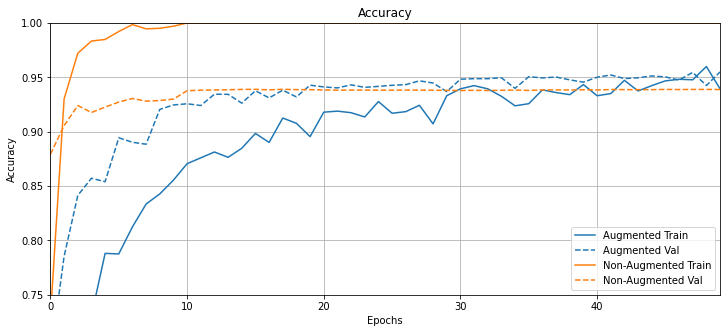

In [0]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Augmented": aug_history, "Non-Augmented": no_aug_history}, metric = "accuracy")
plt.title("Accuracy")
plt.ylim([0.75,1])

(0.0, 1.0)

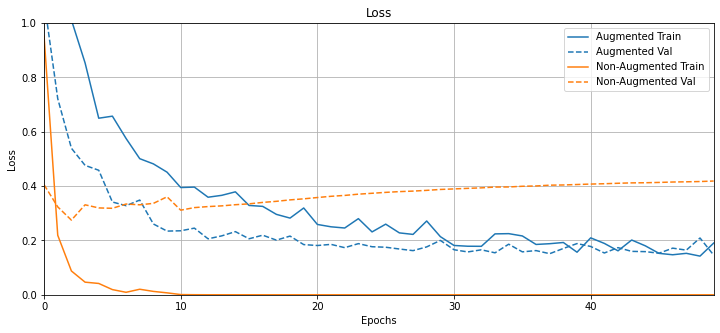

In [0]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Augmented": aug_history, "Non-Augmented": no_aug_history}, metric = "loss")
plt.title("Loss")
plt.ylim([0,1])